<a href="https://colab.research.google.com/github/AnnaVitali/Explainable_AI_Example/blob/master/SHapley_Additive_exPlanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Values

In [1]:
!pip install shap

In [2]:
import shap
import xgboost
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

## Utility function

In [3]:
def compute_mse(preds, labels):
  return np.mean((preds - labels)**2)

## Load the dataset
We'll use the SHAP libtary to compute Shapley values for a model trained on the California Housing Dataset.

In [4]:
cal_housing  = fetch_california_housing()

print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
x = cal_housing.data
y = cal_housing.target
cal_features = cal_housing.feature_names

df = pd.concat((pd.DataFrame(x, columns = cal_features),
                pd.DataFrame({'MedianHouseVal': y})), axis = 1)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

## Train an XGBoost model

The following code block creates and trains an XGBoost model, then create an `Explainer` to compute feature attribution using SHAP. Providing the `Explainer` with an individual prediction returns clculated Shapley values for the example

In [7]:
xgb_reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators = 500)
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:
test_preds = np.squeeze(xgb_reg.predict(x_test))
mse_test = compute_mse(test_preds, y_test)
print(f'The RMSE for our XGBoost model is {np.sqrt(mse_test)}')

The RMSE for our XGBoost model is 0.4527705027321001


## Computation of SHAP values

This approach of creating the explainer on the model, works regarderless of the model architecture or ML framework used.

The `hap_values` is an enumerable corresponding to all the data samples given to explainer to predict.

In [9]:
explainer = shap.Explainer(xgb_reg, feature_names = cal_features)
shap_values = explainer(x_test)

assert shap_values.shape == x_test.shape

### Examine global explanations

The following bar plot show the avarage Shapley value for each feature with a bar plot. This is often referred to as global feature attributions because it gives insight into the most influential features in the model, regarderless of the specific input vlaues

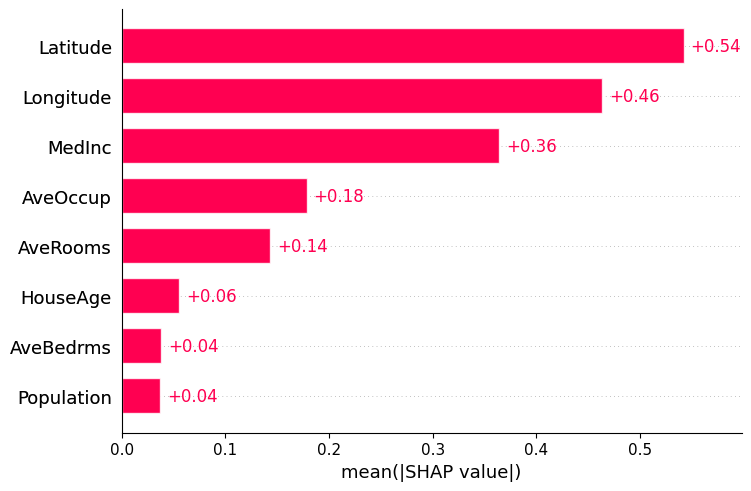

In [10]:
shap.plots.bar(shap_values)

#### Beeswarm plot

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value (shap_values.value[instance,feature]) of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature (shap_values.data[instance,feature]).

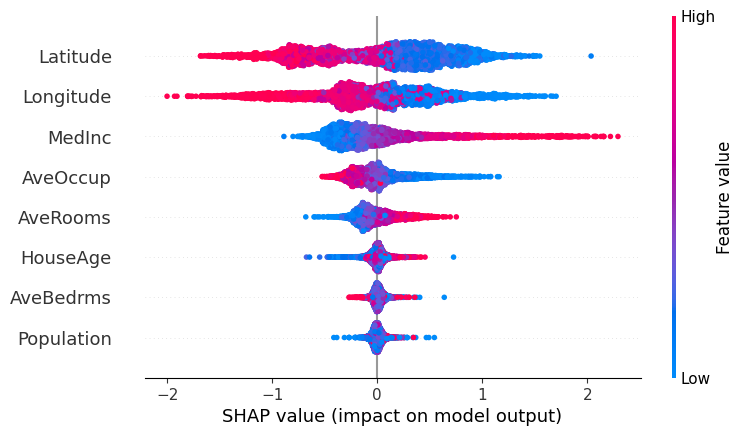

In [12]:
shap.plots.beeswarm(shap_values)

### Individual prediction

We consider the first example of the test set. The baseline prediction for our model is 2.06 and this is the expected value of the model output, the average of the model prediction on all values in the test set. The prediction of our model is 1.03. Each feature attribution is represented as a row in the waterfall, color coded with an arrow for whether the feature contributed positive or negatively toward the final prediction value

MedInc: 	 2.7404
HouseAge: 	 15.0
AveRooms: 	 5.952830188679245
AveBedrms: 	 1.0636792452830188
Population: 	 1207.0
AveOccup: 	 2.8466981132075473
Latitude: 	 36.79
Longitude: 	 -119.69


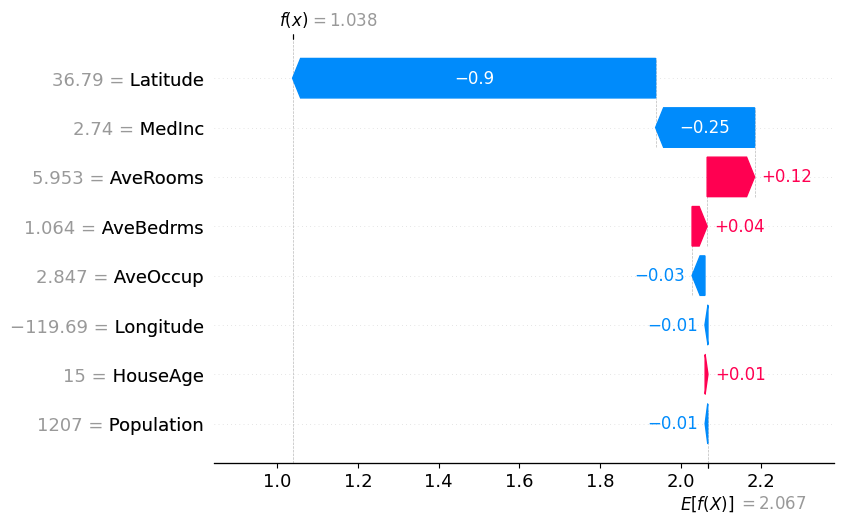

In [13]:
idx = 0
text_example = x_test[idx]
for i, feature in enumerate(cal_features):
  print(f'{feature}: \t {text_example[i]}')

shap.plots.waterfall(shap_values[idx])

In [16]:
first_example_shap = shap_values[0]
shapley_values = first_example_shap.values

print(f'Predicted Value: {first_example_shap.base_values + sum(shapley_values)}\n')
print(f'Baseline: {first_example_shap.base_values} \n')


print('Shapley values for features:')
for i, shapley_value in enumerate(shapley_values):
  print(f'{shap_values.feature_names[i]} {shapley_value}')

print('\nMost to least influential features:')
most_influential_ordering = np.argsort(-np.abs(shapley_values))

for i in range(len(shapley_values)):
  print(f'{shap_values.feature_names[most_influential_ordering[i]]}:  {shapley_values[most_influential_ordering[i]]}')

Predicted Value: 1.0376724977977574

Baseline: 2.0667531490325928 

Shapley values for features:
MedInc -0.24536201357841492
HouseAge 0.006988696753978729
AveRooms 0.1176186352968216
AveBedrms 0.03736382722854614
Population -0.006428723223507404
AveOccup -0.031925514340400696
Latitude -0.8998978734016418
Longitude -0.0074376859702169895

Most to least influential features:
Latitude:  -0.8998978734016418
MedInc:  -0.24536201357841492
AveRooms:  0.1176186352968216
AveBedrms:  0.03736382722854614
AveOccup:  -0.031925514340400696
Longitude:  -0.0074376859702169895
HouseAge:  0.006988696753978729
Population:  -0.006428723223507404


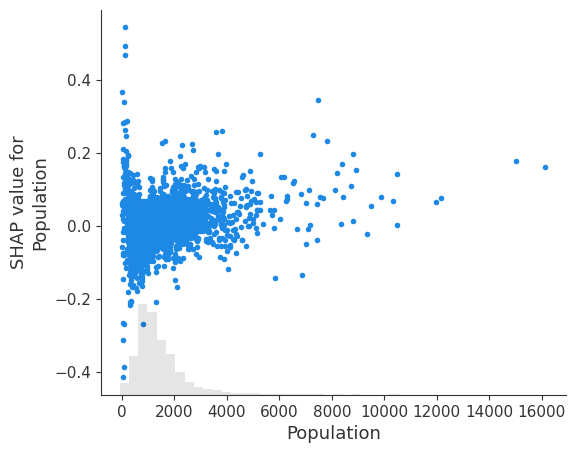

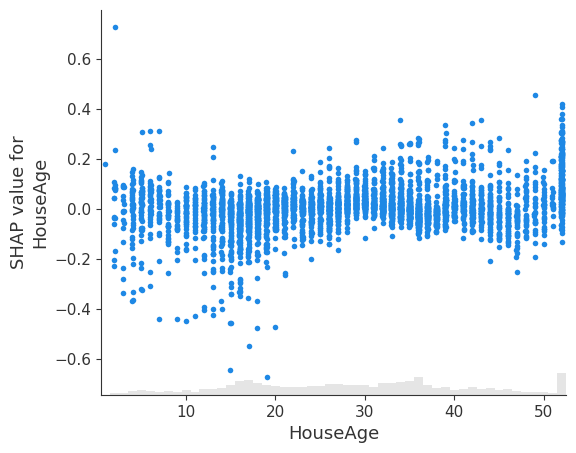

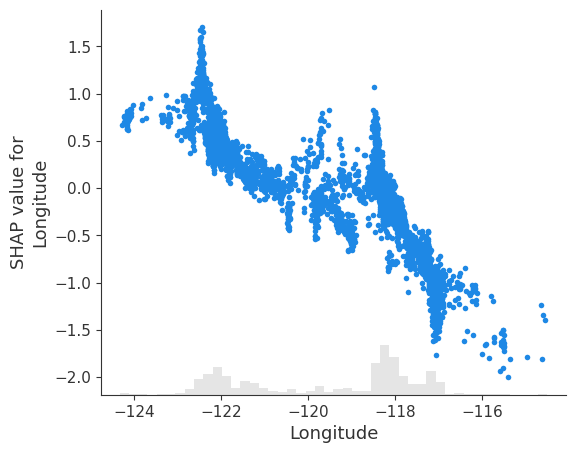

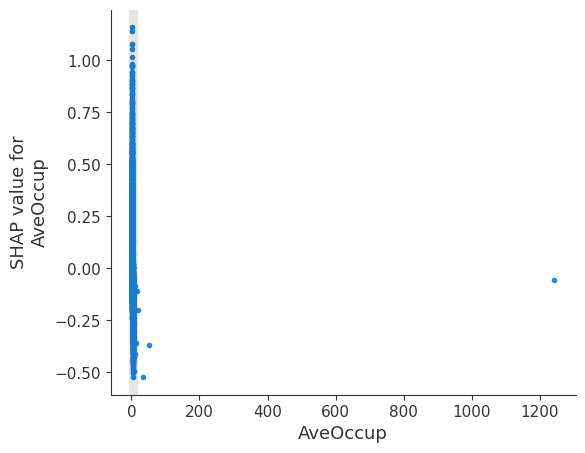

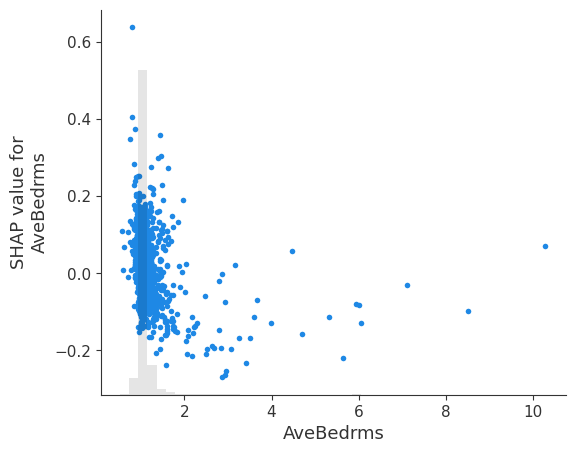

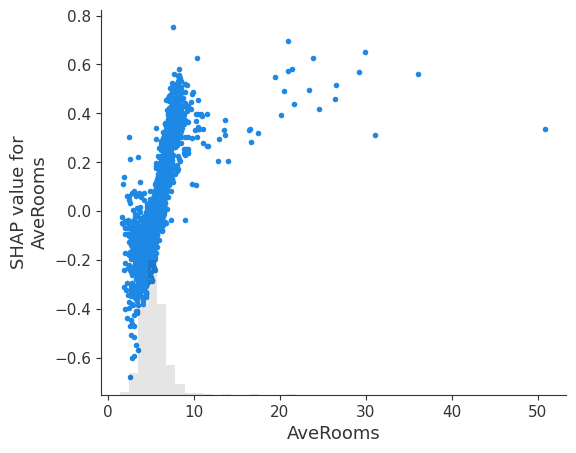

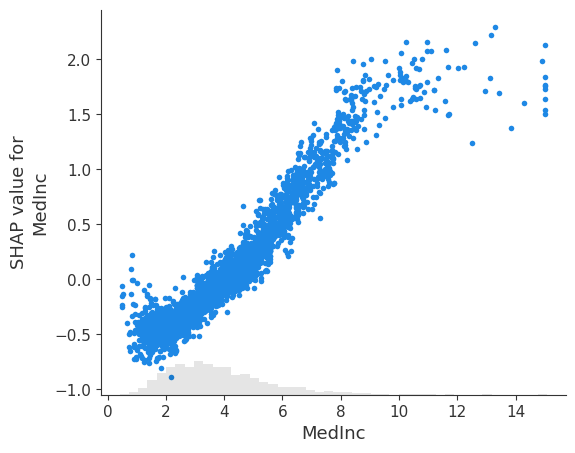

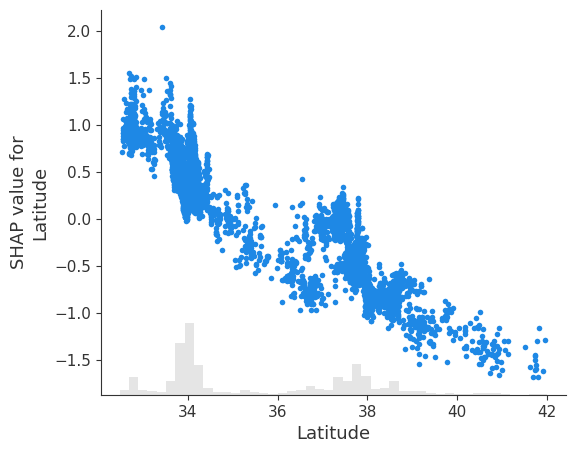

In [20]:
shap.plots.scatter(shap_values[:, "Population"])
shap.plots.scatter(shap_values[:, "HouseAge"])
shap.plots.scatter(shap_values[:, "Longitude"])
shap.plots.scatter(shap_values[:, "AveOccup"])
shap.plots.scatter(shap_values[:, "AveBedrms"])
shap.plots.scatter(shap_values[:, "AveRooms"])
shap.plots.scatter(shap_values[:, "MedInc"])
shap.plots.scatter(shap_values[:, "Latitude"])

By passing the entire `Explanation` object to the scatter plot, we can show which feature is most driving thet interacition effect. In the code below SHAP picks out the feature that has the storngest interaction with `HouseAge`, in this case is `AveOccup`, and plots the two feature together.

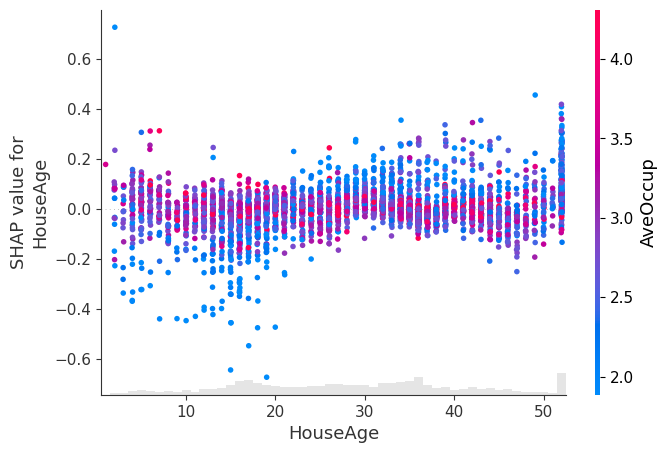

In [21]:
shap.plots.scatter(shap_values[:, "HouseAge"], color = shap_values)